In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pandas as pd
from datetime import datetime
import time
import os
import gzip
import numpy as np
from shapely.geometry import Point
import warnings 
from tqdm import tqdm
import csv
from scipy.stats import ttest_ind

# Load data from 1980-2020
shapefile_path = "data/National_USFS_Fire_Occurrence_Point_FL/usfs_fire_occurrence_cleaned_1980_2020.shp"
gdf = gpd.read_file(shapefile_path)

In [12]:
weather = pd.read_csv('data/weather_data_per_fire.csv')
elevation = pd.read_csv('data/elevations_per_fire.csv')
merged = weather.merge(elevation, on='OBJECTID').merge(gdf, on='OBJECTID')


In [13]:
print(len(merged))

49004


In [21]:
merged['DISCOVERYD'] = pd.to_datetime(merged['DISCOVERYD'], errors='coerce')
merged['FIREOUTDAT'] = pd.to_datetime(merged['FIREOUTDAT'], errors='coerce')
merged['DURATION'] = (merged['FIREOUTDAT'] - merged['DISCOVERYD']).dt.days
merged = merged[merged['DURATION'] >= 0]
merged = merged[merged['DURATION'] <= 300]

### Topography and Elevation Impacts
# Analyze Elevation vs Fire Characteristics
# 🔹 Correlation
merged[['ELEVATION', 'TOTALACRES', 'DURATION']].corr()

,ELEVATION,TOTALACRES,DURATION
ELEVATION,1.000000,0.020895,0.115805
TOTALACRES,0.020895,1.000000,0.208533
DURATION,0.115805,0.208533,1.000000


In [39]:
low = merged[merged['ELEVATION'] < 1000]['DURATION'].dropna()
high = merged[merged['ELEVATION'] >= 1000]['DURATION'].dropna()

t_stat, p_val = ttest_ind(high, low, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


T-statistic: 14.50, p-value: 0.0000


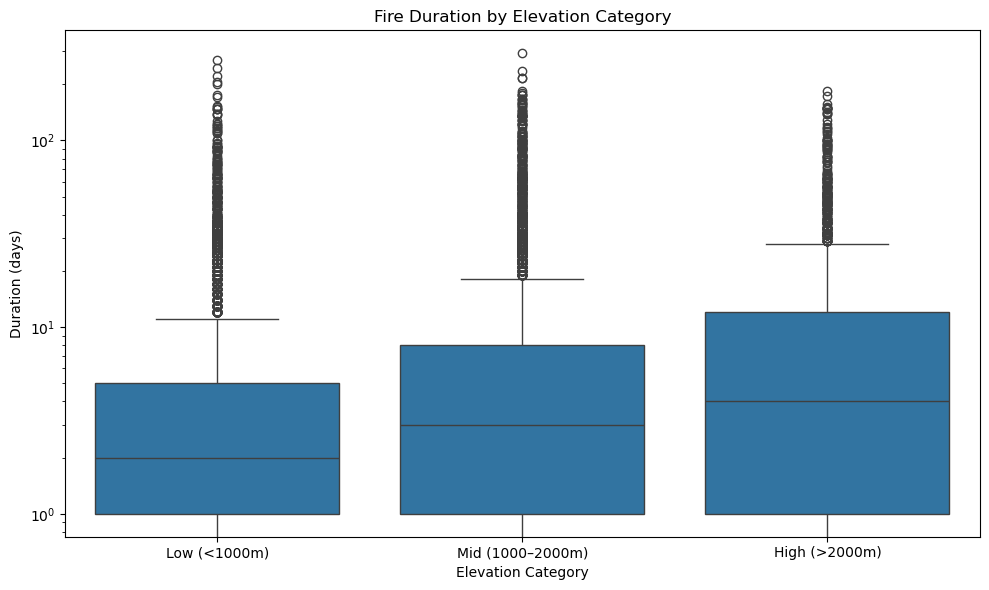

In [48]:
# duration by elevation category
merged['elevation_cat'] = pd.cut(
    merged['ELEVATION'],
    bins=[-float('inf'), 1000, 2000, float('inf')],
    labels=['Low (<1000m)', 'Mid (1000–2000m)', 'High (>2000m)']
)

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='elevation_cat', y='DURATION', data=merged)
plt.yscale('log')  # optional: if distribution is skewed
plt.title('Fire Duration by Elevation Category')
plt.xlabel('Elevation Category')
plt.ylabel('Duration (days)')
plt.tight_layout()
plt.show()

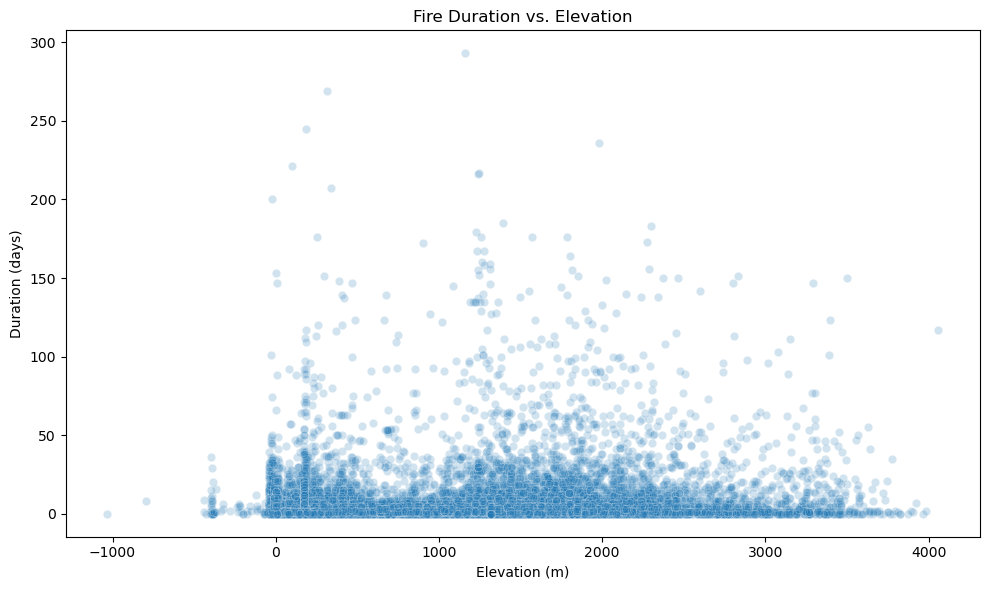

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='ELEVATION', y='DURATION', alpha=0.2)
#plt.yscale('log')  # optional
plt.title('Fire Duration vs. Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Duration (days)')
plt.tight_layout()
plt.show()

In [64]:
fire_data_clean = merged.dropna(subset=['DURATION', 'ELEVATION', 'TOTALACRES', 'STATCAUSE'])
fire_data_clean['log_duration'] = np.log1p(fire_data_clean['DURATION'])
features = fire_data_clean[['ELEVATION', 'TOTALACRES', 'STATCAUSE']]
features_encoded = pd.get_dummies(features, columns=['STATCAUSE'], drop_first=True)
features_encoded = features_encoded.astype(float)

X = sm.add_constant(features_encoded)
y = fire_data_clean['log_duration'].astype(float)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     61.93
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          4.88e-308
Time:                        22:40:43   Log-Likelihood:                -23305.
No. Observations:               15898   AIC:                         4.666e+04
Df Residuals:                   15871   BIC:                         4.687e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [98]:
#threshold for long duration as the 75th percentile
threshold = merged['DURATION'].quantile(0.75)
merged['IS_LOG_DURATION'] = (merged['DURATION'] > threshold).astype(int)

class_proportions = merged['IS_LOG_DURATION'].value_counts(normalize=True)
print("Class proportions:", class_proportions)

print(merged[['DURATION', 'IS_LOG_DURATION']].head())

print("Class distribution in IS_LOG_DURATION:")
print(merged['IS_LOG_DURATION'].value_counts())

if merged['IS_LOG_DURATION'].nunique() > 1:
    # Define features and target variable
    X = merged[['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']]
    y = merged['IS_LOG_DURATION']

    # Train-test split with stratification to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

    # Train the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')  # Class weight to handle imbalance
    clf.fit(X_train, y_train)

    # Evaluate the model
    accuracy = clf.score(X_test, y_test)
    print("Model accuracy:", accuracy)

else:
    print("Error: The target variable is imbalanced with only one class.")

Class proportions: IS_LOG_DURATION
0    0.767524
1    0.232476
Name: proportion, dtype: float64
    DURATION  IS_LOG_DURATION
19        16                1
20         1                0
23         2                0
24         1                0
25         2                0
Class distribution in IS_LOG_DURATION:
IS_LOG_DURATION
0    12242
1     3708
Name: count, dtype: int64
Model accuracy: 0.768025078369906


In [100]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3431  242]
 [ 868  244]]


In [102]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3673
           1       0.50      0.22      0.31      1112

    accuracy                           0.77      4785
   macro avg       0.65      0.58      0.58      4785
weighted avg       0.73      0.77      0.73      4785



In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


def train_fire_spread_model(data, features, target='DURATION'):
    # Split features and target
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    train_data = pd.concat([X_train, y_train], axis=1)
    train_data_clean = train_data.dropna()

    X_train_clean = train_data_clean[features]
    y_train_clean = train_data_clean[target]

    test_data = pd.concat([X_test, y_test], axis=1).dropna()
    X_test_clean = test_data[features]
    y_test_clean = test_data[target]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_clean, y_train_clean)

    y_pred = model.predict(X_test_clean)

    rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
    r2 = r2_score(y_test_clean, y_pred)

    print("Model Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared Score: {r2:.2f}")

    return model, {'rmse': rmse, 'r2': r2}

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
model, metrics = train_fire_spread_model(merged, features, target='DURATION')
model, metrics = train_fire_spread_model(merged, features, target='TOTALACRES')

Model Evaluation:
RMSE: 13.75
R² Score: -0.03
Model Evaluation:
RMSE: 366.48
R² Score: 0.10


In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
target = 'DURATION'

# Drop rows with missing values
data = merged[features + [target]].dropna()

X = data[features]
y = data[target]

# Optional: log-transform the target to reduce skew
y_log = np.log1p(y)  # log(1 + x)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)   # undo log(1 + x)
y_test_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print(f"XGBoost Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

XGBoost Model Evaluation:
RMSE: 14.19
R² Score: 0.07


Confusion Matrix:
[[498   7]
 [ 29   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       505
           1       0.46      0.17      0.25        35

    accuracy                           0.93       540
   macro avg       0.70      0.58      0.61       540
weighted avg       0.91      0.93      0.92       540



C:\Users\gahot\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


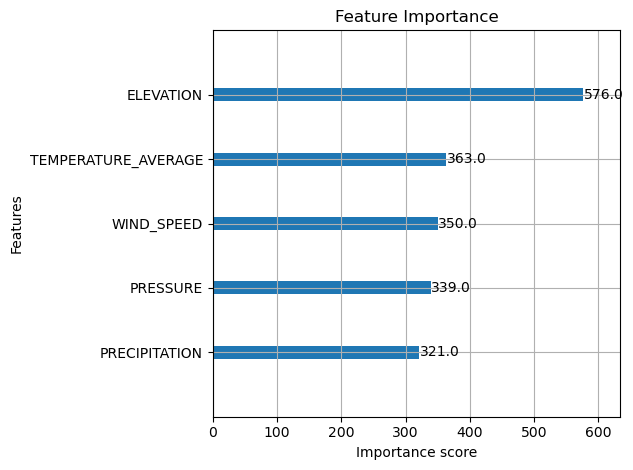

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

merged['IS_LONG_DURATION'] = (merged['DURATION'] > 24).astype(int)

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
X = merged[features]
y = merged['IS_LONG_DURATION']

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 8. Feature importance plot
plot_importance(model)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# investigate if fire cause has any impact on wildfire behavior

In [35]:
merged['CAUSE_GROUP'] = merged['STATCAUSE'].apply(
    lambda x: 'Natural' if x in ['Lightning', 'Other Natural Cause'] else 'Human'
)

# Check the value counts to confirm
print(merged['CAUSE_GROUP'].value_counts())

CAUSE_GROUP
Human      9947
Natural    6003
Name: count, dtype: int64


In [46]:
# 1. T-Test: Compare Duration Between Two Causes (e.g., Human vs. Natural)
import pandas as pd
from scipy.stats import ttest_ind

# Example: Filter for only two causes
df = merged[merged['CAUSE_GROUP'].isin(['Human', 'Natural'])]

# Perform independent t-test
human_dur = df[df['CAUSE_GROUP'] == 'Human']['DURATION']
natural_dur = df[df['CAUSE_GROUP'] == 'Natural']['DURATION']

t_stat, p_val = ttest_ind(human_dur, natural_dur, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")
# There is a statistically significant difference in the duration of wildfires caused by natural versus human sources. 
#  Specifically, human-caused fires tend to last longer.

T-statistic: -14.717
P-value: 0.00000


In [53]:
from scipy.stats import f_oneway
groups = [group['DURATION'].values for name, group in merged.groupby('STATCAUSE') if len(group) > 10]

# one-way ANOVA
f_stat, p_val = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.5f}")

F-statistic: 21.931
P-value: 0.00000


In [55]:
import statsmodels.api as sm

features = ['ELEVATION', 'TEMPERATURE_AVERAGE', 'WIND_SPEED', 'PRECIPITATION', 'PRESSURE']
X = merged[features]
y = merged['DURATION']

df_reg = pd.concat([X, y], axis=1).dropna()
X_clean = df_reg[features]
y_clean = df_reg['DURATION']
X_const = sm.add_constant(X_clean)

model = sm.OLS(y_clean, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               DURATION   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     16.85
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           1.98e-16
Time:                        22:14:45   Log-Likelihood:                -11359.
No. Observations:                2697   AIC:                         2.273e+04
Df Residuals:                    2691   BIC:                         2.277e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  59.5750    